    
# The Taxi Problem
<p align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/6/6e/Taxi_in_New_York_City.jpg" alt="Charging bull" style="width:70%; border:0;">
</p>


Description from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition" by Tom Dietterich ([Github source](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py))

## Description
There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

Map:
```
    +---------+,
    |R: | : :G|
    | : | : : |
    | : : : : |
    | | : | : |
    |Y| : |B: |
    +---------+
```
    
## Actions
There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: drop off passenger

## Observations
There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode. Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination. This gives a total of 404 reachable discrete states. Each state space is represented by the tuple: (taxi_row, taxi_col, passenger_location, destination). An observation is an integer that encodes the corresponding state. The state tuple can then be decoded with the "decode" method.

Passenger locations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
- 4: in taxi

Destinations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)

## Info
``step`` and ``reset()`` will return an info dictionary that contains "p" and "action_mask" containing the probability that the state is taken and a mask of what actions will result in a change of state to speed up training.
As Taxi's initial state is a stochastic, the "p" key represents the probability of the
transition however this value is currently bugged being 1.0, this will be fixed soon.
As the steps are deterministic, "p" represents the probability of the transition which is always 1.0
For some cases, taking an action will have no effect on the state of the agent.
In v0.25.0, ``info["action_mask"]`` contains a np.ndarray for each of the action specifying
if the action will change the state.
To sample a modifying action, use ``action = env.action_space.sample(info["action_mask"])``
Or with a Q-value based algorithm ``action = np.argmax(q_values[obs, np.where(info["action_mask"] == 1)[0]])``.

## Rewards
- -1 per step unless other reward is triggered.
- +20 delivering passenger.
- -10  executing "pickup" and "drop-off" actions illegally.


# Sources for this notebook
OpenAI Gym Taxi environment: ([Github source](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py)) <br>
Q-learning algorithm: [LearningDataSci](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)

## Install and import libraries

In [ ]:
"""Install libraries (outcomment commands by removing # and run cell)"""
#!pip install cmake 'gym[atari]' scipy

In [21]:
"""Import libraries"""
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from time import sleep
from matplotlib import animation

## General functions

In [16]:
def run_animation(experience_buffer):
    """Function to run animation"""
    time_lag = 0.05  # Delay (in s) between frames
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        # Print console output
        print(f"Episode: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        print(f"State: {experience['state']}")
        print(f"Action: {experience['action']}")
        print(f"Reward: {experience['reward']}")

        # Pauze animation
        sleep(time_lag)

In [32]:
def store_episode_as_gif(experience_buffer, path='./', filename='animation2.gif'):
    """Store episode as gif animation"""
    fps = 5   # Set framew per seconds
    dpi = 30  # Set dots per inch
    interval = 50  # Interval between frames (in ms)

    # Retrieve frames from experience buffer
    frames = []
    for experience in experience_buffer:
        frames.append(experience['frame'])

    # Fix frame size
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # Generate animation
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=interval)

    # Save output as gif
    anim.save(path + filename, writer='imagemagick', fps=fps)

## Environment initialization

State space: Discrete(500)
Action space: Discrete(6)
State: 364
Action: 1
Action mask: [1 1 1 0 0 0]
Reward: -1


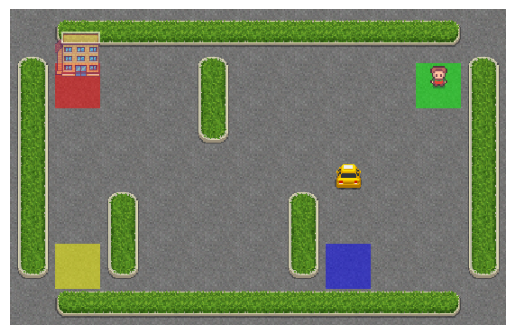

In [25]:
"""Initialize and validate the environment"""
env = gym.make("Taxi-v3", render_mode="rgb_array").env
state, _ = env.reset()

# Print dimensions of state and action space
print("State space: {}".format(env.observation_space))
print("Action space: {}".format(env.action_space))

# Sample random action
action = env.action_space.sample(env.action_mask(state))
next_state, reward, done, _, _ = env.step(action)

# Print output
print("State: {}".format(state))
print("Action: {}".format(action))
print("Action mask: {}".format(env.action_mask(state)))
print("Reward: {}".format(reward))

# Render and plot an environment frame
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()

# Simulation with random agent

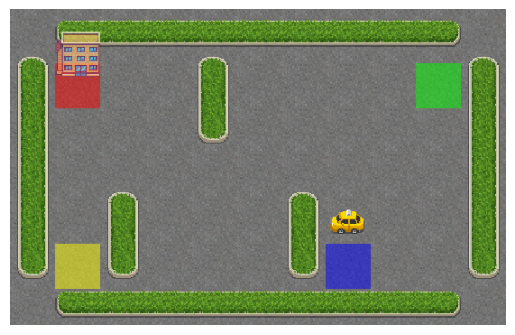

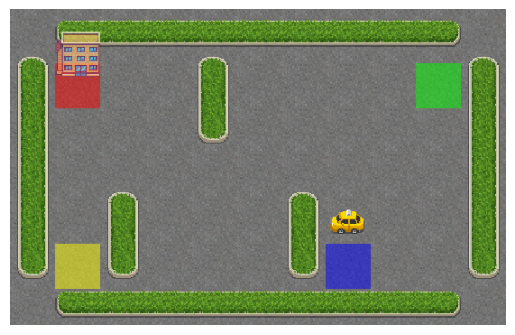

In [ ]:
"""Simulation with random agent"""
epoch = 0
num_failed_dropoffs = 0
experience_buffer = []
cum_reward = 0

done = False

state, _ = env.reset()

while not done:
    # Sample random action
    action = env.action_space.sample()
    #action = env.action_space.sample(env.action_mask(state))

    state, reward, done, _, _ = env.step(action)
    cum_reward += reward

    # Store experience in dictionary
    experience_buffer.append({
        "frame": env.render(),
        "episode": 1,
        "epoch": epoch,
        "state": state,
        "action": action,
        "reward": cum_reward,
        }
    )

    if reward == -10:
        num_failed_dropoffs += 1

    epoch += 1

# Run animation and print console output
run_animation(experience_buffer)

print("# epochs: {}".format(epoch))
print("# failed drop-offs: {}".format(num_failed_dropoffs))

## Training the agent

Episode #: 10000


===Training completed.===



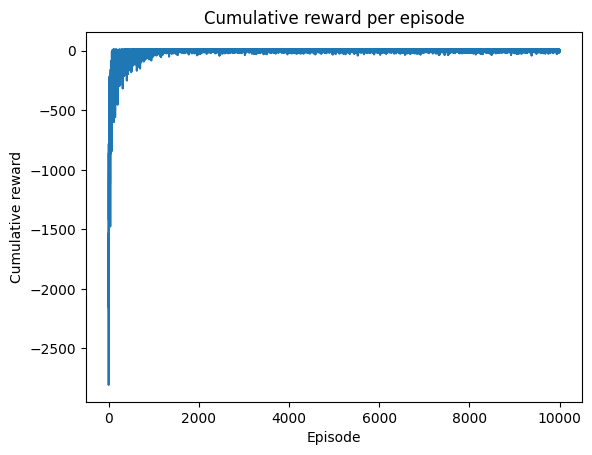

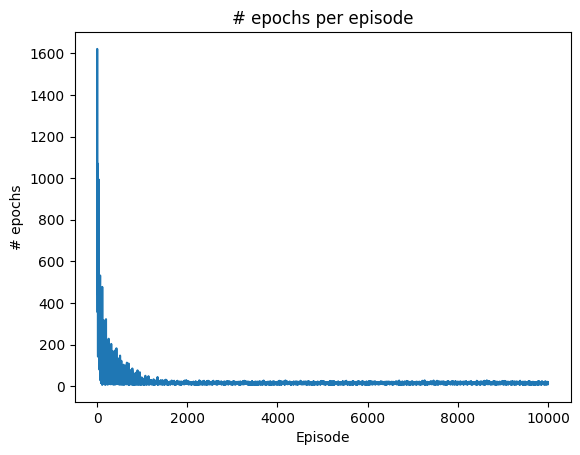

CPU times: user 7.33 s, sys: 2.89 s, total: 10.2 s
Wall time: 7.26 s


In [8]:
%%time 

"""Training the agent"""
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 1.0  # Discount rate
epsilon = 0.1  # Exploration rate
num_episodes = 10000  # Number of episodes

# Output for plots
cum_rewards = np.zeros([num_episodes])
total_epochs = np.zeros([num_episodes])

for episode in range(1, num_episodes+1):
    # Reset environment
    state, info = env.reset()
    epoch = 0 
    num_failed_dropoffs = 0
    done = False
    cum_reward = 0

    while not done:
        
        if random.uniform(0, 1) < epsilon:
            "Basic exploration [~0.47m]"
            action = env.action_space.sample() # Sample random action (exploration)
            
            "Exploration with action mask [~1.52m]"
          # action = env.action_space.sample(env.action_mask(state)) "Exploration with action mask"
        else:      
            "Exploitation with action mask [~1m52s]"
           # action_mask = np.where(info["action_mask"]==1,0,1) # invert
           # masked_q_values = np.ma.array(q_table[state], mask=action_mask, dtype=np.float32)
           # action = np.ma.argmax(masked_q_values, axis=0)

            "Exploitation with random tie breaker [~1m19s]"
          #  action = np.random.choice(np.flatnonzero(q_table[state] == q_table[state].max()))
            
            "Basic exploitation [~47s]"
            action = np.argmax(q_table[state]) # Select best known action (exploitation)
 
        next_state, reward, done, _ , info = env.step(action) 

        cum_reward += reward
        
        old_q_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * next_max)
        
        q_table[state, action] = new_q_value
        
        if reward == -10:
            num_failed_dropoffs += 1

        state = next_state
        epoch += 1
        
        total_epochs[episode-1] = epoch
        cum_rewards[episode-1] = cum_reward

    if episode % 100 == 0:
        clear_output(wait=True)
        print(f"Episode #: {episode}")

print("\n")
print("===Training completed.===\n")

# Plot reward convergence
plt.title("Cumulative reward per episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.plot(cum_rewards)
plt.show()

# Plot epoch convergence
plt.title("# epochs per episode")
plt.xlabel("Episode")
plt.ylabel("# epochs")
plt.plot(total_epochs)
plt.show()

## Performance test

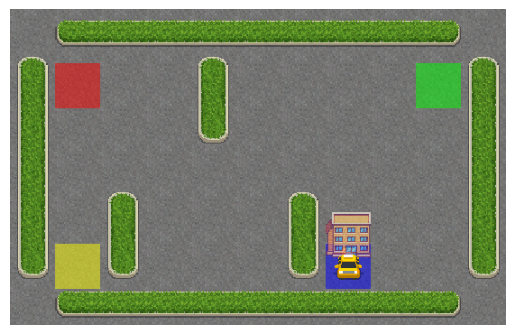

Episode: 1/1
Epoch: 12/12
State: 475
Action: 5
Reward: 9


Test results after 1 episodes:
Mean # epochs per episode: 13.0
Mean # failed drop-offs per episode: 0.0


In [29]:
"""Test policy performance after training"""

num_epochs = 0
total_failed_deliveries = 0
num_episodes = 1
experience_buffer = []
store_gif = True

for episode in range(1, num_episodes+1):
    # Initialize experience buffer

    my_env = env.reset()
    state = my_env[0]
    epoch = 1 
    num_failed_deliveries =0
    cum_reward = 0
    done = False

    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, _, _ = env.step(action)
        cum_reward += reward

        if reward == -10:
            num_failed_deliveries += 1

        # Store rendered frame in animation dictionary
        experience_buffer.append({
            'frame': env.render(),
            'episode': episode,
            'epoch': epoch,
            'state': state,
            'action': action,
            'reward': cum_reward
            }
        )

        epoch += 1

    total_failed_deliveries += num_failed_deliveries
    num_epochs += epoch

    if store_gif:
        store_episode_as_gif(experience_buffer)

# Run animation and print output
run_animation(experience_buffer)

# Print final results
print("\n") 
print(f"Test results after {num_episodes} episodes:")
print(f"Mean # epochs per episode: {num_epochs / num_episodes}")
print(f"Mean # failed drop-offs per episode: {total_failed_deliveries / num_episodes}")